# Natural Language Understanding with Sequence to Sequence Models
## How to predict the intent behind a customer query. Seq2Seq models explained. Slot filling demonstrated on ATIS dataset with Keras.
https://towardsdatascience.com/natural-language-understanding-with-sequence-to-sequence-models-e87d41ad258b

Natural Language Understanding (NLU), the technology behind conversational AI (chatbots, virtual assistant, augmented analytics) typically includes the intent classification and slot filling tasks, aiming to provide a semantic tool for user utterances. Intent classification focuses on predicting the intent of the query, while slot filling extracts semantic concepts in the query. For example the user query could be “Find me an action movie by Steven Spielberg”. The intent here is “find_movie” while the slots are “genre” with value “action” and “directed_by” with value “Steven Spielberg”.


useful links:  
https://towardsdatascience.com/practical-guide-to-attention-mechanism-for-nlu-tasks-ccc47be8d500  
https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03  
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html  
https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html  


### Decoding human intention
In this section, we will implement a sequence-to-sequence model for natural language understanding. Typically, this involves two tasks: Intent Detection (ID) and Slot Filling (SF). The former tries to classify a user utterance into an intent. The latter tries to ﬁnd what are the “arguments” of such intent.

### Exploring the Dataset
We train our model on the well-known ATIS dataset (Airline Travel Information System). A preprocessed version of the dataset in Pickle format was obtained from this repository. The dataset contains queries submitted by travelers to the information system. The intent of the user is labelled as well as the utterance (slot fillings).

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from atis_loader import *
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM
from tensorflow.keras.utils import plot_model

The snippet below stores the train data from dictionaries and tensors in separated variables. It also displays few examples of queries, their word vectors, the intent, the slots and the slots vectors.

In [35]:
# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')

Done  loading:  ./data/atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS show me ground transportation in dallas please EOS
Query vector:  [178 770 581 457 866 482 339 688 179]
Intent label:  ground_service
Slot text:  O O O O O O B-city_name O O
Slot vector:  [128, 128, 128, 128, 128, 128, 17, 128, 128]
**************************************************************************
Query text: BOS all flights from dallas to san francisco EOS
Query vector:  [178 207 429 444 339 851 739 440 179]
Intent label:  flight
Slot text:  O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 48, 128, 78, 125, 128]
**************************************************************************
Query text: BOS please inform me the type of aircraft used on a flight from atlanta to denver before 12 o'clock noon EOS
Query vector:  [178 688 491 581 827 883 646 196 892 654 180 428 444 242 851 351 253  33


Below we display an example query for each intent class in a nice layout.

In [36]:

pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})

df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
  df_small.loc[j] = df[df.intent==i].iloc[0]
  j = j+1
  
df_small

/home/maddalena/venvML/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


In [37]:
print('vocab size: ', len(t2i_train))
print('index of word "town":', t2i_train['town'])
print('word at index 860:', i2t_train[860])

print('index of intent "flight": ', in2i_train['flight'])
print('intent at index 14: ', i2in_train[14])

print('index of slot "B-arrive_time.end_time: "', s2i_train['B-arrive_time.end_time'])
print('slot at index 10: ', i2s_train[10])
print('-------------')
print('query text: ', query_data_train[0])
print('intent: ', intent_data_train[0])
print('slot data: ', slot_data_train[0])
print('-------------')
print('query vector with tokens (BOS, EOS): ', input_tensor_train[0])
print('intent label: ', intent_data_label_train[0])
print('slot vector: ', target_tensor_train[0])



vocab size:  943
index of word "town": 860
word at index 860: town
index of intent "flight":  14
intent at index 14:  flight
index of slot "B-arrive_time.end_time: " 10
slot at index 10:  B-arrive_time.end_time
-------------
query text:   i want to fly from boston at 838 am and arrive in denver at 1110 in the morning 
intent:  flight
slot data:   O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day 
-------------
query vector with tokens (BOS, EOS):  [178 479 902 851 431 444 266 240 168 210 215 236 482 351 240  27 482 827
 606 179]
intent label:  14
slot vector:  [128, 128, 128, 128, 128, 128, 48, 128, 35, 100, 128, 128, 128, 78, 128, 14, 128, 128, 12, 128]


In [38]:
i2s_train_values = list(i2s_train.values())

print("Total slot categories: ", len(i2s_train_values))
print("Slot cat. [0]", i2s_train_values[0])
print("Slot cat. [1]", i2s_train_values[1])
print("...")
print("Slot cat. [127]", i2s_train_values[127])
print("Slot cat. [128]", i2s_train_values[128])


Total slot categories:  129
Slot cat. [0] B-aircraft_code
Slot cat. [1] B-airline_code
...
Slot cat. [127] I-transport_type
Slot cat. [128] O


As an example, let’s consider the user query “i want to fly from boston at 838 am and arrive in denver at 1110 in the morning”. The model should classify this user query as “flight” intent. It should also parse the query, identify and fill all slots necessary for understanding the query. Although the words “I”, “want”, “to”, “fly”, “from”, “at”, “and”, “arrive”, “in”, “the” contribute to understand the context of the intent, the model should correctly label the entities needed to fulfill user’s goal in its intention to take a flight. These are “boston” as departure city (B-fromloc.city), “8:38 am” as departure time (B-depart_time.time), “denver” as destination city (B-toloc.city_name), “11:10” as arrival time (B-arrive_time.time) and “morning” as arrival period of day (B-arrive_time.period_of_day).

As you probably noticed, the text of queries is already tokenized and a vocabulary is also provided in the ATIS dataset. Queries have a start (“BOS”) and end (“EOS”) token, as shown below.

### Creating Tensors
We create tensors by padding each query vector and slot vector to a maximum length. We provide two tensors for the target slots. One is the teacher tensor, which forces the decoder to follow a correct output slot. The other is the true target tensor, which defines what the decoder should output given the teacher tensor. The only difference between the two is that the target tensor is just the teacher tensor shifted left by one slot label. This trick was used for English to Spanish translation with a sequence-to-sequence model (source). Both input and target tensors have the shape (None, 48).

In [39]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [40]:
# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # Padding the input and output tensor to the maximum length
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], len_input, len_target 

In [41]:
input_data_train, teacher_data_train, target_data_train, \
                  len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)

input_data_test, teacher_data_test, target_data_test, \
                 len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)


In [42]:
print("Input train length (query): ", len_input_train)
print("Teacher train length (slot): ", len_target_train)
print("Target train length (teacher tensor shifted by 1): ", len_target_train)
print("------")
print("Shape of input_data_train (query): ", input_data_train.shape)
print("Shape of teacher_data_train (slot): ", teacher_data_train.shape)
print("Shape of target_data_train (slot+1): ", target_data_train.shape)
print("------")
print("input_data_train[0]: ", input_data_train[0])
print("teacher_data_train[0]: ", teacher_data_train[0])
print("target_data_train[0][0]: ", target_data_train[0])

Input train length (query):  48
Teacher train length (slot):  48
Target train length (teacher tensor shifted by 1):  48
------
Shape of input_data_train (query):  (4978, 48)
Shape of teacher_data_train (slot):  (4978, 48)
Shape of target_data_train (slot+1):  (4978, 48, 1)
------
input_data_train[0]:  [178 376 593 409 756 247 179   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
teacher_data_train[0]:  [128 128   2 128 128  17 128   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
target_data_train[0][0]:  [[128]
 [  2]
 [128]
 [128]
 [ 17]
 [128]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 

In other to compute the vocabulary size, we combine train and test vocabularies. The input vocabulary has 943 words, while the output vocabulary has 129 words.

In [43]:
def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size

In [44]:
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

### Building a Seq2Seq Model for Slot Filling
The seq2seq model is created below using a GPU-ready LSTM in the encoder and decoder. The input is put through an encoder model which gives us the encoder output of shape (batch_size, max_length, hidden_size) and the encoder hidden state of shape (batch_size, hidden_size). Both encoder and decoders use an Embedding layer to project the sentences to learn a meaningful representation of the user query, which is fed to a unidirectional LSTM layer with 1024 cells.

In [45]:
BUFFER_SIZE = len(input_data_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024

# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input_train,), name="Encoder_Input") # query
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim, name="Encoder_Embedding")
encoder_lstm = LSTM(units=units, return_sequences=True, return_state=True, name="Encoder_LSTM")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))
encoder_states = [state_h, state_c]

# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,), name="Decoder_Input") # slot
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim, name="Decoder_Embedding")
decoder_lstm = LSTM(units=units, return_sequences=True, return_state=True, name="Decoder_LSTM")
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu", name="Dense_1_relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax", name="Dense_2_softmax")
# Drop-out is added in the dense layers to help mitigate overfitting in this part of the model.
decoder_out = decoder_d2(Dropout(rate=.4, name="Dropout_1")(decoder_d1(Dropout(rate=.4, name="Dropout_2")(decoder_lstm_out))))

# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
#  encoder_inputs=[batch,encoded_words] from input (query)
#  decoder_inputs=[batch,encoded_words] from output (slots). This is the "teacher tensor".
#  decoder_out=[batch,encoded_words] from output (slots). This is the "target tensor".
model = Model([encoder_inputs, decoder_inputs], decoder_out, name="training_model",)
# Use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "training_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
Decoder_Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_Embedding (Embedding)   (None, 48, 256)      241408      Encoder_Input[0][0]              
__________________________________________________________________________________________________
Decoder_Embedding (Embedding)   (None, None, 256)    33024       Decoder_Input[0][0]              
_____________________________________________________________________________________

In [46]:
model.save('model_save/training_model.h5')

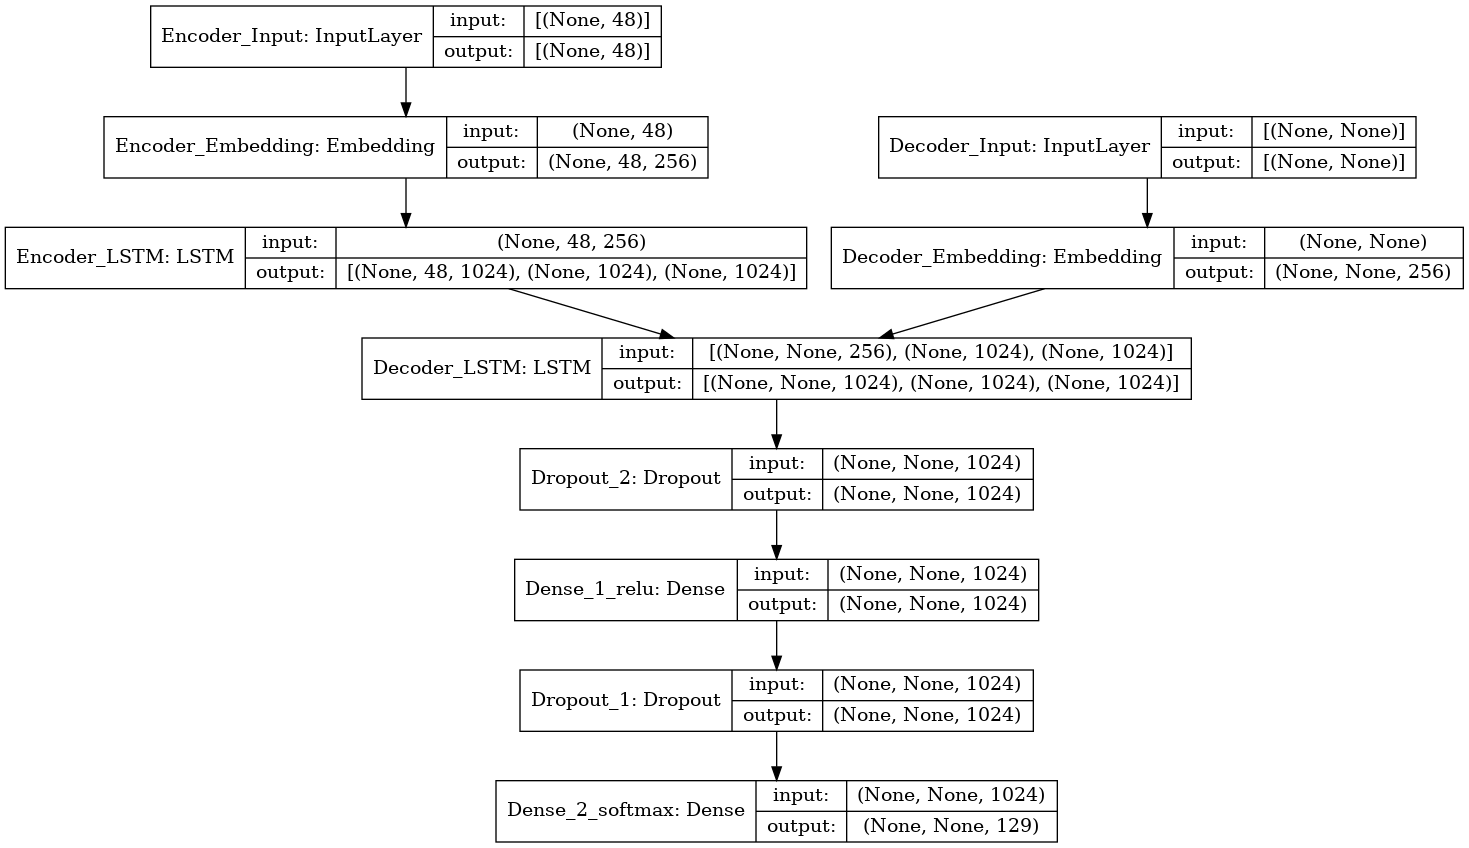

In [47]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training a Seq2Seq Model
Because our targets (slots vectors) are not one-hot encoded, we use sparse categorical crossentropy as loss function. With Adam as optimizer in 50 epochs, we use 3982 training samples, and 996 validation samples. Accuracy is up to 98% on the training data with a validation accuracy just below 96%. The validation accuracy starts to plateau around epoch 45, suggesting this model isn’t really inferring anymore and is starting overfitting.

In [48]:
epochs = 25

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model_save/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True),
]

history = model.fit([input_data_train, teacher_data_train], target_data_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs,
                 #callbacks=my_callbacks,            
                 validation_data=([input_data_test, teacher_data_test], target_data_test))
                 

Epoch 1/25
78/78 [==============================] - 324s 4s/step - loss: 1.0488 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.4614 - val_sparse_categorical_accuracy: 0.8901
Epoch 2/25
78/78 [==============================] - 348s 4s/step - loss: 0.4529 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.4115 - val_sparse_categorical_accuracy: 0.8997
Epoch 3/25
78/78 [==============================] - 345s 4s/step - loss: 0.3852 - sparse_categorical_accuracy: 0.9095 - val_loss: 0.3338 - val_sparse_categorical_accuracy: 0.9201
Epoch 4/25
78/78 [==============================] - 340s 4s/step - loss: 0.3367 - sparse_categorical_accuracy: 0.9184 - val_loss: 0.3004 - val_sparse_categorical_accuracy: 0.9242
Epoch 5/25
78/78 [==============================] - 342s 4s/step - loss: 0.3064 - sparse_categorical_accuracy: 0.9238 - val_loss: 0.2834 - val_sparse_categorical_accuracy: 0.9286
Epoch 6/25
78/78 [==============================] - 351s 4s/step - loss: 0.2918 - sparse_categorical_accu

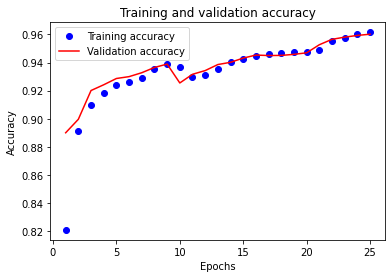

In [49]:
def plot_training_accuracy(history):

  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()
  
plot_training_accuracy(history)

### Inference with a Seq2Seq Model
Prediction will require two separate models from training. We need to break up the encoder and decoder mechanisms. We then run the entire input sequence through the encoder, then create the output by predicting with the decoder one step at a time.

### Create the encoder model
Create the encoder model from the tensors we previously declared.

In [50]:

# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c], name='encoder_model')
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Input (InputLayer)   [(None, 48)]              0         
_________________________________________________________________
Encoder_Embedding (Embedding (None, 48, 256)           241408    
_________________________________________________________________
Encoder_LSTM (LSTM)          [(None, 48, 1024), (None, 5246976   
Total params: 5,488,384
Trainable params: 5,488,384
Non-trainable params: 0
_________________________________________________________________


In [51]:
encoder_model.save('model_save/encoder_model.h5')

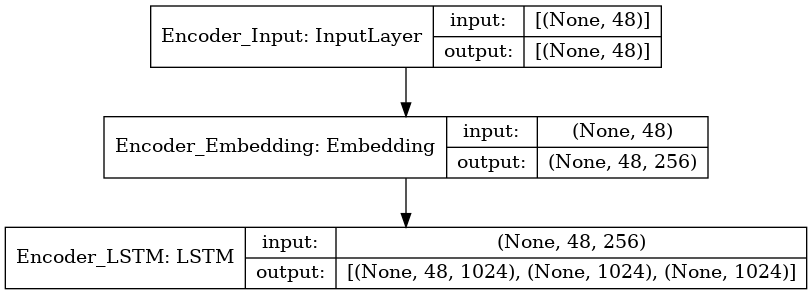

In [52]:
plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

### Create inference Model

In [53]:

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")

# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units,), name="state_input_h")
state_input_c = Input(shape=(units,), name="state_input_c")

decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])

inf_decoder_out = decoder_d2(decoder_d1(decoder_res))

inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c], name='inf_model')

In [54]:
inf_model.summary()

Model: "inf_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inf_decoder_inputs (InputLayer) [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_Embedding (Embedding)   (None, None, 256)    33024       inf_decoder_inputs[0][0]         
__________________________________________________________________________________________________
state_input_h (InputLayer)      [(None, 1024)]       0                                            
__________________________________________________________________________________________________
state_input_c (InputLayer)      [(None, 1024)]       0                                            
__________________________________________________________________________________________

In [55]:
inf_model.save('model_save/inf_model.h5')

Load the inference model

In [56]:
#inf_model = tf.keras.models.load_model('model_save/inf_model.h5')
#encoder_model = tf.keras.models.load_model('model_save/encoder_model.h5')

In [57]:
def preprocess_query(w):
    w = w.rstrip().strip().lower()
    w = "BOS " + w + " EOS"
    return w

# Converts the given query (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (query)
# or target (slot)
# Output is 1-D: [timesteps/words]
def query_to_vector(query, len_input=len_input_train, t2i=t2i_train):
    pre = preprocess_query(query)
    vec = np.zeros(len_input)
    query_list = [t2i[s] for s in pre.split(' ')]
    for i,w in enumerate(query_list):
        vec[i] = w
    return vec

In [58]:
query_to_vector('what is the cheapest flight from boston to san francisco')

array([178., 916., 498., 827., 296., 428., 444., 266., 851., 739., 440.,
       179.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.])

### Predict
Given an input string, an encoder model (infenc_model) and a decoder model (infmodel), return a predicted slot string.

In [59]:
def predict_slots(input_query, infenc_model, infmodel, 
                  len_input=len_input_train, 
                  t2i=t2i_train, s2i=s2i_train, i2s=i2s_train,
                  len_target=len_target_train,
                  attention=False):

    sent_len = len(input_query.split())
    sv = query_to_vector(input_query, len_input, t2i)
    
    # Reshape so we can use the encoder model. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)

    i = 0
    start_vec = s2i["O"]
    stop_vec = s2i["O"]
    
    # We will continuously feed cur_vec as an input into the decoder to produce the next word,
    # which will be assigned to cur_vec. Start it with "EOS".
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "BOS"
    output_query = ""
    
    # Start doing the feeding. Terminate when the model predicts an "EOS" or we reach the end
    # of the max target slot length.
    while cur_word != "EOS" and i < (len_target-1) and i < sent_len+1:
        i += 1
        if cur_word != "BOS":
            output_query = output_query + " " + cur_word
        x_in = [cur_vec, sh, sc]
        
        # This will allow us to accomodate attention models, which we will talk about later.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        
        # The output of the model is a massive softmax vector with one spot for every possible word. Convert
        # it to a word ID using argmax().
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = i2s[np.argmax(nvec[0,0])]

    return output_query    

In [60]:
input_query = "what is the cheapest flight from boston to san francisco "
print(predict_slots(input_query, encoder_model, inf_model))

 O O O B-flight_mod O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name
